In [22]:
import Utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
df_cancer = Utils.get_cancer_data()

## Introduction
<p>According to the American Cancer Association, 1.8 million cancer cases were expected in the United States 2020, and 606,520 Americans are expected to die.  But the cancer daeth rate per 100,000 residents varies across counties in the United States from a low of 60 deaths in Pitkin County, Colorado to a high of 360 in Union County, Florida.  Why is that one county would have 6 times the deaths from cancer than another county?  Using data shared on data.world, I investigate the relationship between cancer rates and several socio-economic variables from 2010-2016 by fitting a least squares linear regression model to the data.</p>

## Research Questions
<ol><li>Can socio-economic variable be used to predict cancer death rates in the United States?</li>
    <li>Assuming that they can, which group of socio-economic variables (Population, Age, Income, Education, Health Coverage, Race) has the greatest impact, as defined by the sum of the absoulte values of the coefficients, on a county's death rate?</li>
    <li>Which socio-economic variables are positively related to cancer death rates and which socio-economic variables are negatively related to cancer death rates?</li>
    
    


## Exploratory Analysis
<ol><li>Plot Response Variable</li>
    <li>Plot Representative Predictor/Response Scatters</li></ol>

### 1. Response Variable Histogram
<p>The response variable, target_deathrate, exhibits a normal-like distribution.  From the historgram it is apparent there is at least on outlier just above 360 deaths per 100,000 people.</p>

Text(0.5, 0.01, 'Deaths per 100,000')

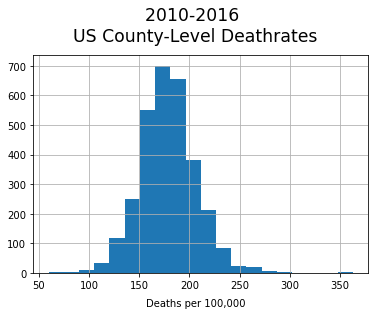

In [3]:
#https://stackoverflow.com/questions/32685185/pandas-histogram-labels-and-title
fig, axes = plt.subplots(nrows=1, ncols=1)
df_cancer['target_deathrate'].hist(bins=20)
plt.suptitle('2010-2016 \nUS County-Level Deathrates', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.01,'Deaths per 100,000', ha='center')
#fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')

### 2. Predictor Response Scatters
<p>The 31 numeric predictors can be classified by one of three reponse-predictor scatter plot shapes: weak linear relationships, funnel shapes, and disjointed.</p>

#### Weak Linear Relationships (both positive/negative)
<p>Examplified by 'povertypercent'</p>
['incidencerate','medincome', 'povertypercent','percentmarried', 'pctnohs18_24', 
       'pcths18_24', 'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over',
       'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
       'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
       'pctmarriedhouseholds']

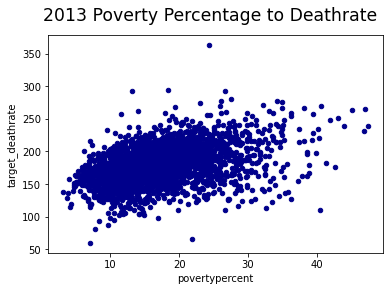

In [4]:
df_cancer.plot.scatter(x='povertypercent',y='target_deathrate',c='DarkBlue')
plt.suptitle('2013 Poverty Percentage to Deathrate', x=0.5, y=.98, ha='center', fontsize='xx-large')
plt.show()

#### Funnel Shapes (both from the left and right)
<p>Examplified by 'studypercap'</p>
['avganncount', 'avgdeathsperyear', 'pctasian', 'pctbachdeg18_24', 'pctblack',
       'pctotherrace', 'pctwhite', 'popest2015','studypercap']

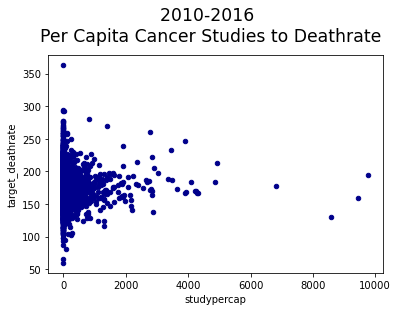

In [5]:
df_cancer.plot.scatter(x='studypercap',y='target_deathrate',c='DarkBlue')
plt.suptitle('2010-2016 \nPer Capita Cancer Studies to Deathrate', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.show()

#### No Observable Relationship
<p>Examplified by 'medianagemale'</p>
['avghouseholdsize',  'birthrate', 'medianage', 'medianagefemale', 'medianagemale', 'pctsomecol18_24']

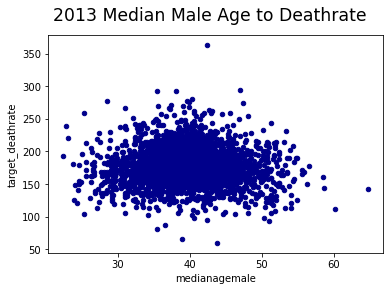

In [6]:
df_cancer.plot.scatter(x='medianagemale',y='target_deathrate',c='DarkBlue')
plt.suptitle('2013 Median Male Age to Deathrate', x=0.5, y=.98, ha='center', fontsize='xx-large')
plt.show()

## Data Cleaning
<ol><li>Drop Outliers from Response Variable</li>
    <li>Drop Observations with bad data</li></ol>

In [7]:
# 1. Drop 56 rows with Response Variable Outliers
df_cancer = Utils.drop_outliers(df_cancer,'target_deathrate')
# 2.a. Drop observations with median age > 100 years (Most people don't live to be 100)
df_cancer.drop(df_cancer[(df_cancer['medianage'] > 100)].index,inplace=True)
# 2.b. Drop observations with avghouseholdsize < 1.  
    #(American Community Service define Avg HH as the number of people living in occupied 
    #   housing units by the total number of occupied housing units.)
df_cancer.drop(df_cancer[df_cancer['avghouseholdsize'] < 1].index,inplace=True)

## Feature Engineering
<ol><li>Drop Variables with Null Values</li>
    <li>Drop Variables with type object </li></ol>

In [8]:
# 1. Drop variables with null values
cols_w_null_values = ['pctsomecol18_24','pctprivatecoveragealone','pctemployed16_over']  
df_cancer.drop(cols_w_null_values,axis=1,inplace=True)
# 2. Drop variables with object type
cols_w_type_obj = df_cancer.dtypes[df_cancer.dtypes == 'object'].index.to_list()
df_cancer.drop(cols_w_type_obj,axis=1,inplace=True)

## Modeling 
<ol><li>Standardize Predictors</li>
    <li>Run Linear Regression on all Variables</li>
    <li>Run on all Significant Variables</li>
    <li>Run on all Variables showing linear relationship</li>
    <li>Lasso Regularization</li>
    <li>Ridge Regularization</li>
    <li>Select Best Model and Run Regression</li></ol>

### 1. Standardize Predictors

In [9]:
df_X_train, df_y_train, df_X_test, df_y_test = (
    Utils.create_train_test_data_sets(df_cancer,'target_deathrate', .2,42))

In [10]:
df_X_train_trans, df_X_test_trans = Utils.standardize_training_test_data(df_X_train,df_y_train,df_X_test,df_y_test)
df_X_train_trans.insert(0,column='const',value=1)
df_X_test_trans.insert(0,column='const',value=1)

### 2. Run Linear Regression on all Variables

In [11]:
res = Utils.statsmodel_ols (df_X_train_trans,df_y_train)
print(res.summary(alpha=.05))

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     77.69
Date:                Mon, 12 Oct 2020   Prob (F-statistic):          1.01e-306
Time:                        19:05:43   Log-Likelihood:                -9988.9
No. Observations:                2316   AIC:                         2.004e+04
Df Residuals:                    2287   BIC:                         2.020e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    178

### 3. Run Linear Regression on all Significant Variables

In [12]:
not_significant_variables = ['medincome','povertypercent','studypercap',
                             'medianage','medianagemale','medianagefemale',
                             'percentmarried','pctnohs18_24','pctbachdeg18_24',
                             'pctbachdeg18_24','pctpubliccoverage','pctpubliccoveragealone',
                             'pctblack','pctasian','pctmarriedhouseholds']
df_X_train_trans_sig = df_X_train_trans.drop(columns=not_significant_variables)

Mean Squared Error: 334.70090317939935
Root Mean Squared Error: 18.294832690664304
R^2: 0.4744516329909857
                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     148.4
Date:                Mon, 12 Oct 2020   Prob (F-statistic):          1.38e-308
Time:                        19:40:50   Log-Likelihood:                -10018.
No. Observations:                2316   AIC:                         2.007e+04
Df Residuals:                    2301   BIC:                         2.015e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------

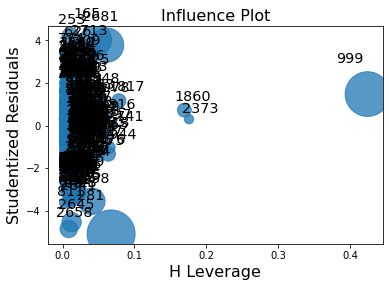

In [24]:
Utils.sklearn_linear_regression(df_X_train_trans_sig,df_y_train)
res = Utils.statsmodel_ols (df_X_train_trans_sig,df_y_train)
print(res.summary(alpha=.05))

### 4. Run Linear Regression on Variables with weak Linear Relationship

In [14]:
weak_linear_relation_variables = ['incidencerate','medincome', 'povertypercent',
                                   'percentmarried', 'pctnohs18_24', 'pcths18_24',
                                   'pcths25_over', 'pctbachdeg25_over', 'pctunemployed16_over',
                                   'pctprivatecoverage', 'pctempprivcoverage', 
                                   'pctpubliccoverage', 'pctpubliccoveragealone', 
                                   'pctmarriedhouseholds']
df_X_train_trans_w_linear = df_X_train_trans.drop(columns=weak_linear_relation_variables)

In [15]:
Utils.sklearn_linear_regression(df_X_train_trans_w_linear,df_y_train)

Mean Squared Error: 507.2598429621768
Root Mean Squared Error: 22.52242977483062
R^2: 0.20349906562657427


### 5. Run Lasso Regression on All Variables

In [16]:
Utils.sklearn_lasso_reg(df_X_train_trans,df_y_train, 1)

Mean Squared Error: 360.6091793553914
Root Mean Squared Error: 18.989712461103547


### 6. Run Ridge Regression on All Variables

In [17]:
Utils.sklearn_ridge_reg(df_X_train_trans,df_y_train)

Mean Squared Error: 341.9007066482476
Root Mean Squared Error: 18.490557229252115


### Select Best Model and Run Regression
<p>Using Mean Squared Error as the model selection criterion, the Ridge Regression model was the best model. Below is the Final MSE, RMSE, and R^2 associated with the test data.  In addition, the coefficients of the linear model are provided as is a Residuals Plot.</p>

Final Mean Squared Error: 315.17583495296566
Final Root Mean Squared Error: 17.753192246831713
R^2: 0.4640462707111185 

              predictors  coefficients
0                  const      0.000000
1            avganncount     -7.824948
2       avgdeathsperyear      9.872728
3          incidencerate      9.471455
4             popest2015     -2.908292
5       avghouseholdsize     -2.162571
6             pcths18_24      1.563043
7           pcths25_over      2.768204
8      pctbachdeg25_over     -6.012739
9   pctunemployed16_over      1.349479
10    pctprivatecoverage     -7.785520
11    pctempprivcoverage      4.467134
12              pctwhite     -2.826524
13          pctotherrace     -2.576040
14             birthrate     -1.014174


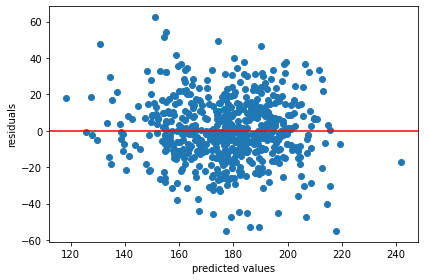

In [18]:
df_X_test_trans_sig = df_X_test_trans.drop(columns=not_significant_variables)
df_coefs = Utils.sklearn_linear_regression_predict(df_X_train_trans_sig,df_y_train,df_X_test_trans_sig,df_y_test)

#### Influence Plot
<p>The influence plot suggests that there is a high-leverage point.</p>

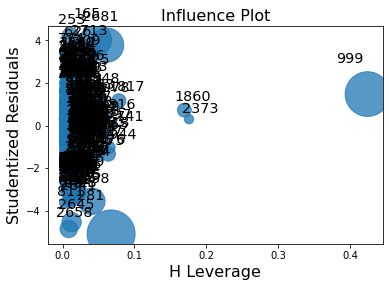

In [26]:
sm.graphics.influence_plot(res)
plt.show()

In [19]:
socio_econ_factors = {'Disease' : ['avganncount','avgdeathsperyear','avgdeathsperyear','incidencerate',],
                     'Population' : ['popest2015','avghouseholdsize','birthrate'],
                     'Age': [], 'Income' : ['pctunemployed16_over'], 'Education' : ['pcths18_24','pcths25_over','pctbachdeg25_over'],
                     'Insurance' : ['pctprivatecoverage','pctempprivcoverage'], 'Race': ['pctwhite','pctotherrace']}
socio_econ_factors_sumabs = [] 
for key in socio_econ_factors.keys():
    socio_econ_factors_sumabs.append(np.abs(df_coefs.loc[df_coefs.predictors.isin(socio_econ_factors[key]),'coefficients']).sum())
list(socio_econ_factors.keys())
df_socio_econ_sumabs = pd.DataFrame({'Factors' : list(socio_econ_factors.keys()), 'SumABS_coeff' :socio_econ_factors_sumabs})
df_socio_econ_sumabs.sort_values(by='SumABS_coeff',ascending=False)

,Factors,SumABS_coeff
0,Disease,27.169131
5,Insurance,12.252654
4,Education,10.343987
1,Population,6.085037
6,Race,5.402564
3,Income,1.349479
2,Age,0.000000


In [20]:
df_coefs.sort_values(by='coefficients')

,predictors,coefficients
1,avganncount,-7.824948
10,pctprivatecoverage,-7.785520
8,pctbachdeg25_over,-6.012739
4,popest2015,-2.908292
12,pctwhite,-2.826524
13,pctotherrace,-2.576040
5,avghouseholdsize,-2.162571
14,birthrate,-1.014174
0,const,0.000000
9,pctunemployed16_over,1.349479


## Results and Discussion

<p>The process of identifying the 'best' model to predict target deathrates in counties in the United States was fascinating.  I generally used the root mean squared error (RMSE) as the metric for identifying the best model.  However, I began by running the statsmodels least squares linear regression model because it shows the p-values for each predictor and I wanted to see what a model with only significant predictors looked like.  Having run the statsmodel and identified the variables with significant p-values and understanding that a significant p-value is not conclusive (particularly when p > n, which is not the case here), I then ran the sklearn linear regression model on all the significant predictors.  The result was slightly worse than the model as deterimned by R^2 with all predictors, which is to be expected as R^2 increases with the number of predictors.  The RMSE for this model was 18.3.</p>

<p>I then transitioned to determining the best model overall using only the mean squared error.  My next attempt was to create a linear regression model--this time with sklearn--that was based on predictors that appeared to have a linear relationship with target_deathrate when plotted in a scatter plot.  This model was surprisingly bad.  RMSE jumped up to 22.5.  My initial assumption was that RMSE would drop if I only used variables that appeared to have a linear relationship with target_deathrate.</p>

<p>Next I returned to using all of the predictors in the linear regression model, but this time I used regularization to help with the selection of optimal coefficients.  I models using both Lasso Regularization and Ridge Regularization.  The results were RMSE of 18.9 and 18.5 respectively.  My  expectation was that either Ridge or Lasso regularization would provide the best result, but both are inferior to the RMSE for the model with the signficant predictors.</p>

<p>As a result, my final model was based on the 'significant variables' from the statsmodel linear regression model.  This model had the lowest RMSE of all, 17.75.  However, as I resviewed the model and identified the most important predictors in estimating the target_deathrate variable, I realized that there was a flaw in my methodology.  What originally interested me was which socio-economic factors could be the best predictors for cancer deaths.  But the three variables with the highest absolute value of coefficients are not socio-economic.  I should have excluded those variables at the beginning.</p>

<b>Potential Pitfalls:</b><br><br>
<b>Non-Linearity of the Data:</b> <p>The residuals plot displays a random pattern suggesting Linearity of the data.</p>
<b>Correlation of Error Terms:</b> <p>The residuals plot displays a random pattern suggesting no correlation of error terms.</p>
<b>Non-Constant Variance of Error Terms:</b> <p>The residuals plot displays a random pattern suggesting a constant variance.</p>
<b>High Leverage Points:</b> <p>The influence plot of the final model suggests that there is a least one high-leverage point.</p>
<b>Outliers:</b> <p>The influence plot of the final model suggests that there is a least one outlier.</p>
<br>
<br>
### Research Questions
<p>Can socio-economic variable be used to predict cancer death rates in the United States?</p>
<p>The F-statistic for the significant predictors is 148, which shows that the coefficients are significant</p>

<p>Which group of socio-economic variables (Population, Age, Income, Education, Health Coverage, Race) has the greatest impact, as defined by the sum of the absoulte values of the coefficients, on a county's death rate?</p>
<p>Putting aside the impact of coefficients related to Disease, the category that had the greatest impact on cancer deathrates per 100,000 (target_deathrate) was Insurance.  But drawing a conclusion from the Insurance variables is challenging.  The percentage of residents in a county with private insurance was negatively related to the target_deathrate, which makes sense.  However, the percentage of residents in a county with employer provided private insurance was positively related to the target_deathrate variable, which, on the face of it does not make sense.  Intuitively, the more private insurance available, the lower the target_deathrate should be.  This finding requires more investigation.</p>

<p>Which socio-economic variables are positively related to cancer death rates and which socio-economic variables are negatively related to cancer death rates?</p>

<p>Socio-economic variables positively realted to cancer are: percent unemployed over 16 years of age, percent 18 - 24 with only a high school education, percent 25 and older with only a high school education, percent with employer private coverage, incident rate, and average deaths per year.</p>
<p>Socio-economic variables negatively realted to cancer are: average annual count of cancer cases, percent with private health coverage, percent 25 and older with a bachelors degree, population in 2015, percent white, percent other race, average household size, and birthrate.</p>
<p>Generally these findings make sense with the notable exceptions of average annual count of cancer cases, which one would expect to be positively related to deathrate and again the percent with employer provided health coverage.</p>

### Video Link: https://youtu.be/F2165qdX5SA

## Data Dictionary
<ul><li><b>TARGET_deathRate: Dependent variable. Mean per capita (100,000) cancer mortalities(a)</li>
<li><b>avgAnnCount:</b> Mean number of reported cases of cancer diagnosed annually(a)</li>
<li><b>avgDeathsPerYear:</b> Mean number of reported mortalities due to cancer(a)</li>
<li><b>incidenceRate:</b> Mean per capita (100,000) cancer diagoses(a)</li>
<li><b>medianIncome:</b> Median income per county (b)</li>
<li><b>popEst2015:</b> Population of county (b)</li>
<li><b>povertyPercent:</b> Percent of populace in poverty (b)</li>
<li><b>studyPerCap:</b> Per capita number of cancer-related clinical trials per county (a)</li>
<li><b>binnedInc:</b> Median income per capita binned by decile (b)</li>
<li><b>MedianAge:</b> Median age of county residents (b)</li>
<li><b>MedianAgeMale:</b> Median age of male county residents (b)</li>
<li><b>MedianAgeFemale:</b> Median age of female county residents (b)</li>
<li><b>Geography:</b> County name (b)</li>
<li><b>AvgHouseholdSize:</b> Mean household size of county (b)</li>
<li><b>PercentMarried:</b> Percent of county residents who are married (b)</li>
<li><b>PctNoHS18_24:</b> Percent of county residents ages 18-24 highest education attained: less than high school (b)</li>
<li><b>PctHS18_24:</b> Percent of county residents ages 18-24 highest education attained: high school diploma (b)</li>
<li><b>PctSomeCol18_24:</b> Percent of county residents ages 18-24 highest education attained: some college (b)</li>
<li><b>PctBachDeg18_24:</b> Percent of county residents ages 18-24 highest education attained: bachelor's degree (b)</li>
<li><b>PctHS25_Over:</b> Percent of county residents ages 25 and over highest education attained: high school diploma (b)</li>
<li><b>PctBachDeg25_Over:</b> Percent of county residents ages 25 and over highest education attained: bachelor's degree (b)</li>
<li><b>PctEmployed16_Over:</b> Percent of county residents ages 16 and over employed (b)</li>
<li><b>PctUnemployed16_Over:</b> Percent of county residents ages 16 and over unemployed (b)</li>
<li><b>PctPrivateCoverage:</b> Percent of county residents with private health coverage (b)</li>
<li><b>PctPrivateCoverageAlone:</b> Percent of county residents with private health coverage alone (no public assistance) (b)</li>
<li><b>PctEmpPrivCoverage:</b> Percent of county residents with employee-provided private health coverage (b)</li>
<li><b>PctPublicCoverage:</b> Percent of county residents with government-provided health coverage (b)</li>
<li><b>PctPubliceCoverageAlone:</b> Percent of county residents with government-provided health coverage alone (b)</li>
<li><b>PctWhite:</b> Percent of county residents who identify as White (b)</li>
<li><b>PctBlack:</b> Percent of county residents who identify as Black (b)</li>
<li><b>PctAsian:</b> Percent of county residents who identify as Asian (b)</li>
<li><b>PctOtherRace:</b> Percent of county residents who identify in a category which is not White, Black, or Asian (b)</li>
<li><b>PctMarriedHouseholds:</b> Percent of married households (b)</li>
<li><b>BirthRate:</b> Number of live births relative to number of women in county (b)</li></ul>

(a): years 2010-2016

(b): 2013 Census Estimates